# Transformer based model to translate English text to Python code

The goal is to  write a transformer-based model that can translats English text to python code(with proper whitespace indentations)

The training dataset contains around 4600+ examples of English text to python code. 
- must use transformers with self-attention, multi-head, and scaled-dot product attention in the model
- There is no limit on the number of training epochs or total number of parameters in the model
- should have trained a separate embedding layer for python keywords and paid special attention to whitespaces, colon and other things (like comma etc)
- model should to do proper indentation
- model should to use newline properly
- model should understand how to use colon (:)
- model should generate proper python code that can run on a Python interpreter and produce proper results


Some preprocessing checks on the dataset should be carried out like:
 - the dataset provided is divided into English and "python-code" pairs properly
the dataset does not have anomalies w.r.t. indentations (like a mixed-use of tabs and spaces, or use of either 4 or 3 spaces, it should be 4 spaces only). Either use tabs only or 4 spaces only, not both
- the length of the "python-code" generated is not out of your model's capacity


In [1]:
!pip install torchtext==0.6.0

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
from torchtext import data 
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import unicodedata
import codecs
import csv
import time
import random
import re
import os
import pickle
from io import open
import itertools
import math
import pandas as pd
from torchtext.data import Field, BucketIterator, LabelField, TabularDataset

BASE_DIR='/content/drive/MyDrive/seq2py'
#https://stackoverflow.com/questions/62922640/calling-a-function-in-a-different-python-file-using-google-colab
%cd $BASE_DIR/utils
import preprocess, helper

/content/drive/MyDrive/seq2py/utils


In [4]:
#Then set a random seed for deterministic results/reproducability.
SEED = 2434
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

#Data Processing

The first step towards any machine learning is input data processing, the input in our case is going to be the English text and output would be a python source code. However, computers don't understand text the only language they understand is of matrices and numbers, we will therefore have to transform the input text into numbers.

So to do that, first we take all the words present in the training data and create a vocabulary out of it. If our training data is as big as a wikipedia, our vocabulary can be composed of all the words in english language. Next, we assign a numeric index next to each word and then we pick only the words that occur in the current input text. Therefore, what gets fed into the transformer are not the english words or python syntax but their corresponding indices.

In next few blocks lets first, preprocess and prepare the data before we feed it to the transformer model.

In [5]:
datasets = preprocess.read_data(file_name=os.path.join(BASE_DIR,'data/english_python_data_cleaned.txt'))
df = preprocess.tranform_to_dataframe(datasets)
df.head()

,Description,Code
1,write a python program to add two numbers,\nnum1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\np...
2,write a python program to subtract two numbers,\nnum1 = 6\nnum2 = 3\ndiff = num1 - num2\nprin...
3,write a python function to add two user provid...,"def add_two_numbers(num1, num2):\n sum = nu..."
4,write a program to find and print the largest ...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >= n...
5,write a program to find and print the smallest...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <= n...


TorchText's Fields handle how data should be processed.

We set the tokenize argument to the correct tokenization function for each, with English being the SRC (source) field and python code being the TRG (target) field. The field also appends the "start of sequence" and "end of sequence" tokens via the init_token and eos_token arguments, and converts all words to lowercase (only for src), batch_first is set to True so that TorchText can return the tensors of dimension [batch size, sequence length].

In [6]:
SRC = Field(tokenize= preprocess.tokenize_en, 
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=True,
            batch_first=True)

TRG = Field(tokenize = preprocess.tokenize_python, 
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=False,
            batch_first=True)

# Having defined those fields, we now need to produce a list that maps them onto the list of rows that are in the CSV:
fields = [('Description', SRC),('Code',TRG)]

Armed with our declared fields, lets convert from pandas to list to torchtext.

In [7]:
example = [data.Example.fromlist([df.Description.iloc[i],df.Code.iloc[i]], fields) for i in range(df.shape[0])] 

#create dataset
python_dataset = data.Dataset(example, fields)

#Finally, we can split into training and validation sets by using the split() method:
(train_data, valid_data,test_data) = python_dataset.split(split_ratio=[0.80, 0.10,0.10], random_state=random.seed(SEED))



In [8]:
len(train_data), len(valid_data), len(test_data)

(3528, 441, 441)

In [9]:
print(vars(train_data.examples[0]))


{'Description': ['write', 'a', 'python', 'function', 'to', 'remove', 'leading', 'zeros', 'from', 'an', 'ip', 'address'], 'Code': ['import', 're', '\n', 'regex', '=', "'\\.[0]*'", '\n', 'def', 'remove_leading_zeros', '(', 'ip', ')', ':', '\n', '\t', 'modified_ip', '=', 're', '.', 'sub', '(', 'regex', ',', "'.'", ',', 'ip', ')', '\n', 'return', 'modified_ip', '', '', '']}


Then create our vocabulary, converting all tokens appearing less than twice into

In [10]:
SRC.build_vocab(train_data)
TRG.build_vocab(train_data)

In [11]:
#save the dictionary as pickle file to be used during inference
with open(os.path.join(BASE_DIR ,"model/src_stio.pkl"),"wb") as f:
  pickle.dump(SRC.vocab.stoi,f)
with open(os.path.join(BASE_DIR ,"model/src_itos.pkl"),"wb") as f:
  pickle.dump(SRC.vocab.itos,f)


#save the dictionary as pickle file to be used during inference
with open(os.path.join(BASE_DIR ,"model/trg_stio.pkl"),"wb") as f:
  pickle.dump(TRG.vocab.stoi,f)
with open(os.path.join(BASE_DIR ,"model/trg_itos.pkl"),"wb") as f:
  pickle.dump(TRG.vocab.itos,f)

The final step of preparing the data is to create the iterators. These can be iterated on to return a batch of data which will have a src attribute (the PyTorch tensors containing a batch of numericalized source sentences) and a trg attribute (the PyTorch tensors containing a batch of numericalized target sentences). Numericalized is just a fancy way of saying they have been converted from a sequence of readable tokens to a sequence of corresponding indexes, using the vocabulary.

When we get a batch of examples using an iterator, we use a BucketIterator instead of the standard Iterator as it creates batches in such a way that it minimizes the amount of padding in both the source and target sentences.

In [12]:
BATCH_SIZE=32
train_iterator, valid_iterator,test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.Code),
    device = device)

#Seq2Seq

In [13]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]


        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]        
        return output, attention

# Encoder

In [14]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 2000):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]

        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
 
            
        return src

In [15]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

# Multi-head Attention Layer

In [16]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

# Position-wise Feedforward Layer

Another key component in the Transformer block is called position-wise feed-forward network (FFN) this is relatively simple compared to the multi-head attention layer. It accepts a 3-dimensional input with shape [batch size, sequence length, hid dimension].

The position-wise FFN consists of two dense layers. Since the same two dense layers are used for each position item in the sequence, we referred to it as position-wise. It is equivalent to applying two 1×1 convolution layers.

The input is transformed from hid_dim to pf_dim, where pf_dim is usually a lot larger than hid_dim. The ReLU activation function and dropout are applied before it is transformed back into a hid_dim representation.

In [17]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

#Decoder

In [18]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 2000):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [19]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

# Training the Seq2Seq Model
Now we have our model implemented, we can begin training it.

First, we'll initialize our model, we define all of the hyperparameters, initialize the encoder and decoder, and initialize the overall model - placing it on the GPU if we have one.

In [20]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)


dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT,
              device)

In [21]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [22]:
print(f'The model has {helper.count_parameters(model):,} trainable parameters')

The model has 8,588,897 trainable parameters


In [23]:
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
model.apply(helper.initialize_weights);
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = helper.train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = helper.evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = helper.epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(BASE_DIR,"model/tut6-model.pt"))
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 13s
	Train Loss: 4.597 | Train PPL:  99.180
	 Val. Loss: 3.153 |  Val. PPL:  23.399
Epoch: 02 | Time: 0m 13s
	Train Loss: 2.988 | Train PPL:  19.852
	 Val. Loss: 2.691 |  Val. PPL:  14.747
Epoch: 03 | Time: 0m 14s
	Train Loss: 2.598 | Train PPL:  13.433
	 Val. Loss: 2.477 |  Val. PPL:  11.911
Epoch: 04 | Time: 0m 13s
	Train Loss: 2.351 | Train PPL:  10.496
	 Val. Loss: 2.281 |  Val. PPL:   9.786
Epoch: 05 | Time: 0m 13s
	Train Loss: 2.155 | Train PPL:   8.625
	 Val. Loss: 2.134 |  Val. PPL:   8.450
Epoch: 06 | Time: 0m 13s
	Train Loss: 1.992 | Train PPL:   7.333
	 Val. Loss: 2.036 |  Val. PPL:   7.660
Epoch: 07 | Time: 0m 13s
	Train Loss: 1.858 | Train PPL:   6.412
	 Val. Loss: 1.963 |  Val. PPL:   7.120
Epoch: 08 | Time: 0m 13s
	Train Loss: 1.737 | Train PPL:   5.682
	 Val. Loss: 1.899 |  Val. PPL:   6.680
Epoch: 09 | Time: 0m 13s
	Train Loss: 1.622 | Train PPL:   5.061
	 Val. Loss: 1.825 |  Val. PPL:   6.202
Epoch: 10 | Time: 0m 13s
	Train Loss: 1.523 | Train PPL

In [ ]:
# Specify a path
PATH = "seq2py_entire_model.pt"

# Save
torch.save(net, PATH)

# Load
model = torch.load(PATH)
model.eval()

In [24]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    assert n_rows * n_cols == n_heads
    fig = plt.figure(figsize=(15,25))
    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()
        cax = ax.matshow(_attention, cmap='bone')
        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [25]:
example_idx = 2

src = vars(train_data.examples[example_idx])['Description']
trg = vars(train_data.examples[example_idx])['Code']

print(f'src = {src}')
print(f'trg = {trg}')
print(" ".join(trg).replace(' . ','.'))

src = ['write', 'a', 'python', 'program', 'to', 'print', 'bitwise', 'and', 'operation']
trg = ['a', '=', '60', '\n', 'b', '=', '13', '\n', 'a_and_b', '=', 'a', '&', 'b', '\n', 'print', '(', 'a_and_b', ')', '', '']
a = 60 
 b = 13 
 a_and_b = a & b 
 print ( a_and_b )  


In [26]:
translation, attention = helper.predict_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

print(" ".join(translation))

predicted trg = ['a', '=', '60', '\n', 'b', '=', '60', '\n', 'b', '=', '13', '\n', 'a_and_b', '=', 'a', '&', 'b', '\n', 'print', '(', 'a_and_b', ')', '', '', '<eos>']
a = 60 
 b = 60 
 b = 13 
 a_and_b = a & b 
 print ( a_and_b )   <eos>


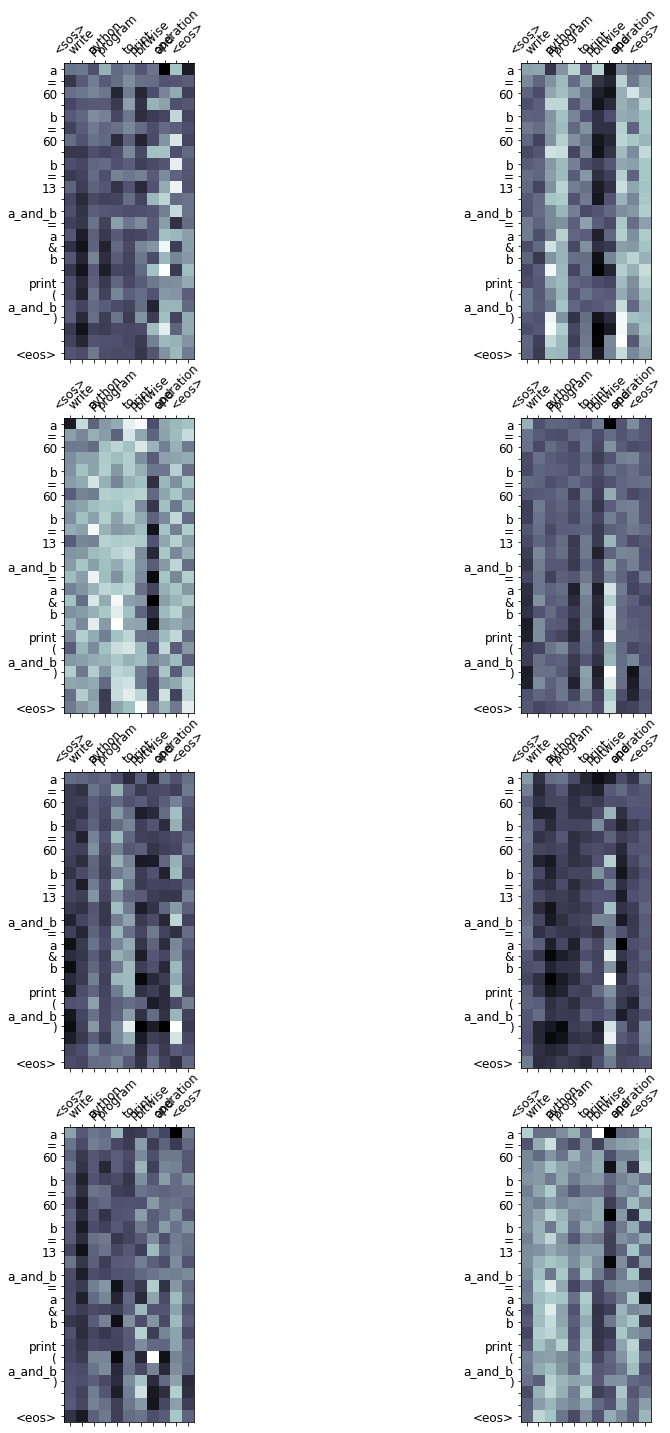

In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rc('axes', unicode_minus=False)
display_attention(src, translation, attention)

In [28]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['Description']
trg = vars(valid_data.examples[example_idx])['Code']

print(f'src = {src}')
print(f'trg = {trg}')

print(" ".join(trg))

src = ['write', 'a', 'function', 'to', 'calculate', 'and', 'return', 'the', 'average', 'of', 'input', 'numbers']
trg = ['\n', 'def', 'calc_avg', '(', '*', 'args', ')', ':', '\n', '\t', 'if', 'len', '(', 'args', ')', '>', '0', ':', '\n', '\t\t', 'return', 'sum', '(', 'args', ')', '/', 'len', '(', 'args', ')', '\n', '', 'return', 'None', '', '', '']

 def calc_avg ( * args ) : 
 	 if len ( args ) > 0 : 
 		 return sum ( args ) / len ( args ) 
  return None   


In [29]:
translation, attention = helper.predict_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')
print(" ".join(translation))

predicted trg = ['def', 'get_weighted_average', '(', 'numbers', ',', 'weightage', ')', ':', '\n', '\t', 'return', 'sum', '(', 'x', '*', 'y', 'for', 'x', 'in', 'numbers', ')', '/', '2', '', '', '<eos>']
def get_weighted_average ( numbers , weightage ) : 
 	 return sum ( x * y for x in numbers ) / 2   <eos>


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


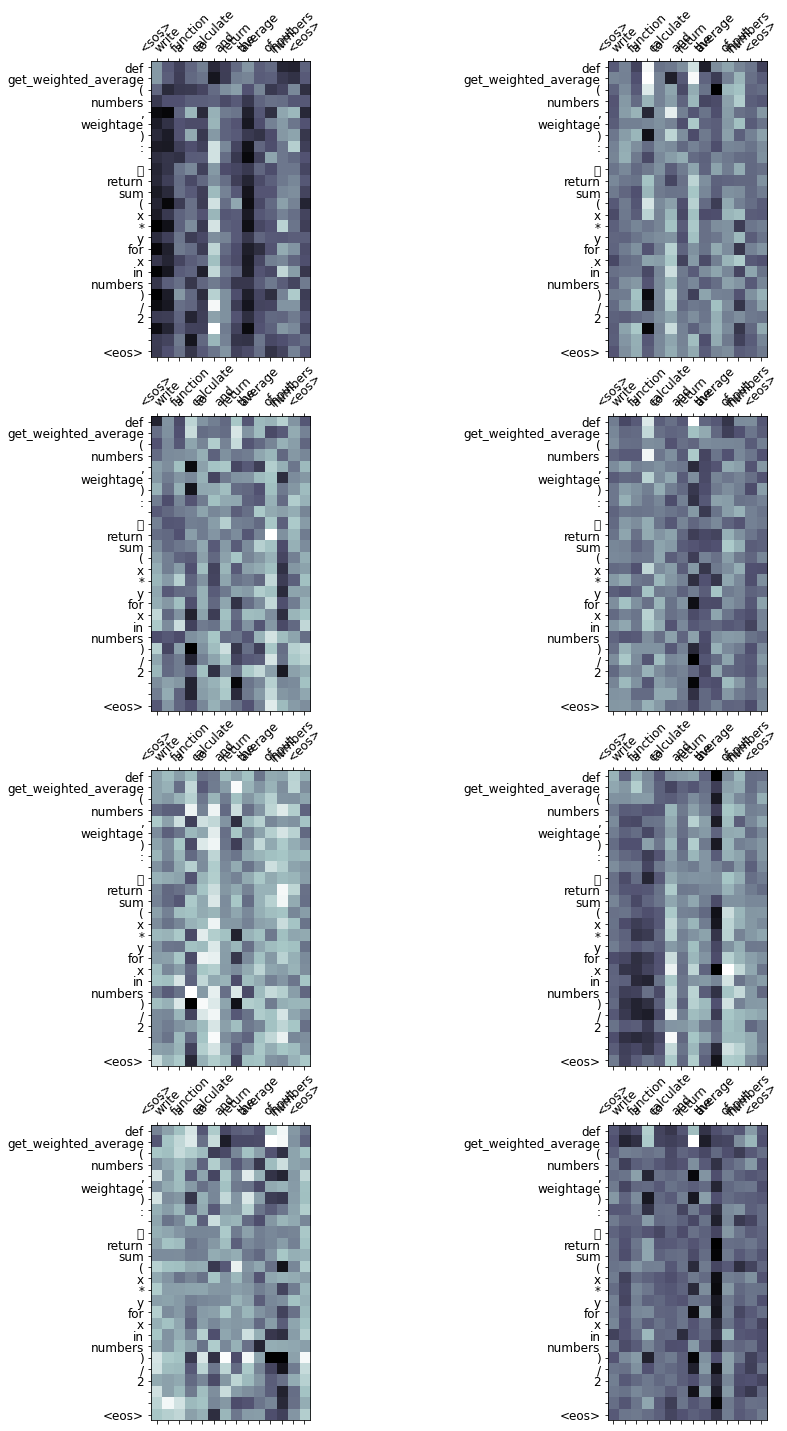

In [30]:
display_attention(src, translation, attention)

In [31]:
example_idx = 7

src = vars(test_data.examples[example_idx])['Description']
trg = vars(test_data.examples[example_idx])['Code']

print(f'src = {src}')
print(f'trg = {trg}')

print(" ".join(trg))

src = ['please', 'write', 'a', 'program', 'to', 'output', 'a', 'random', 'even', 'number', 'between', '0', 'and', '10', 'inclusive', 'using', 'random', 'module', 'and', 'list', 'comprehension', '.']
trg = ['import', 'random', '\n', 'print', '(', 'random', '.', 'choice', '(', '[', 'i', 'for', 'i', 'in', 'range', '(', '11', ')', 'if', 'i', '%', '2', '==', '0', ']', ')', ')', '', '']
import random 
 print ( random . choice ( [ i for i in range ( 11 ) if i % 2 == 0 ] ) )  


In [32]:
translation, attention = helper.predict_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

print(" ".join(translation))

predicted trg = ['import', 'random', '\n', '\n', 'print', '(', 'random', '.', 'sample', '(', '[', 'i', 'for', 'i', 'in', 'range', '(', '5', ')', 'if', 'i', '%', '7', '==', '0', ']', ')', '', '', '<eos>']
import random 
 
 print ( random . sample ( [ i for i in range ( 5 ) if i % 7 == 0 ] )   <eos>


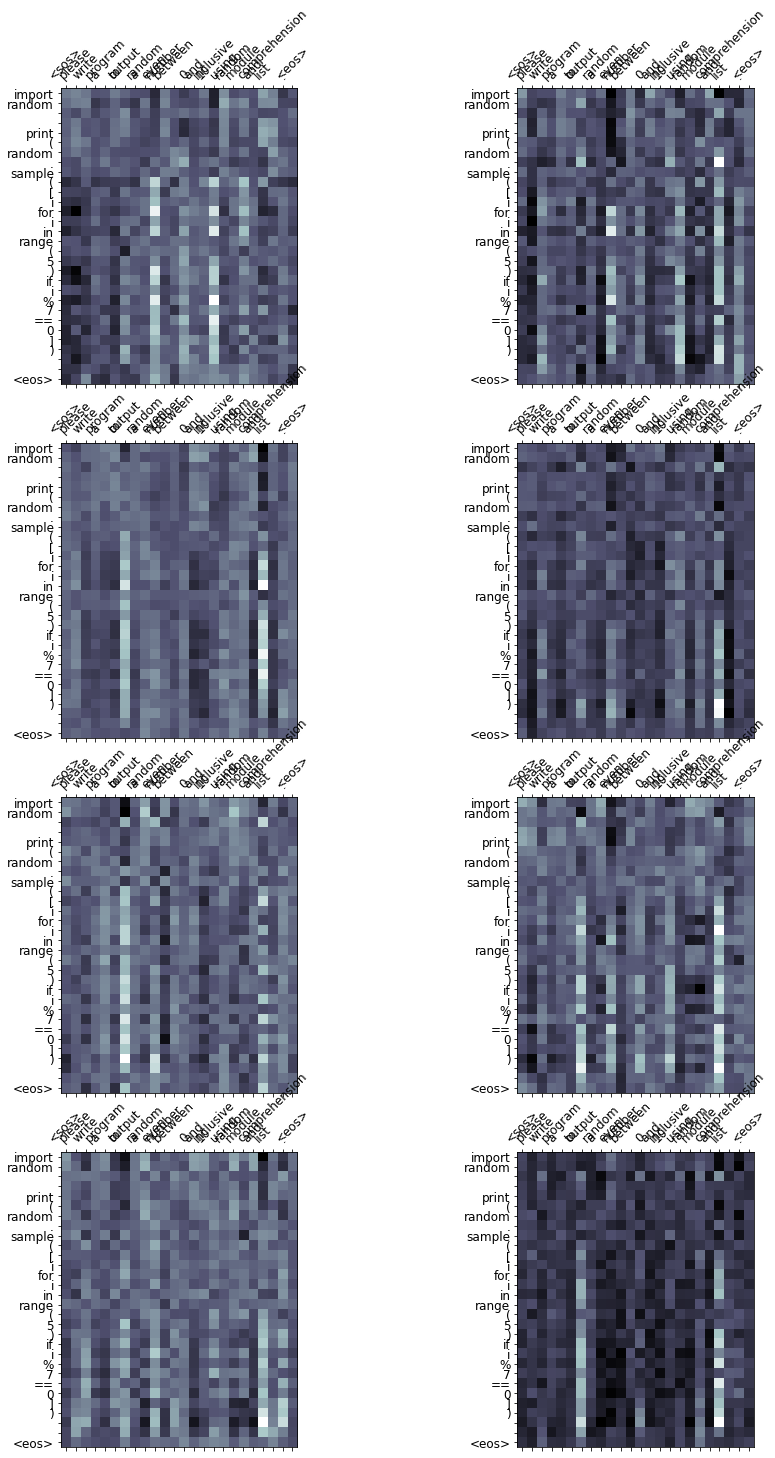

In [33]:
display_attention(src, translation, attention)